<a href="https://colab.research.google.com/github/VincentGaoHJ/Course-CS5242/blob/master/practice_6_imageTaggingAndPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 6: Image Tagging and NN Pruning

In this practical tutorial, we are going to solve a multi-label classification task, i.e., celebrity attribute tagging, as well as get to know NN pruning techniques.

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
import time
from tqdm import tqdm
from pprint import pprint

First mount your Google Drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Data Pre-processing

> **CelebFaces Attributes Dataset (CelebA)** is a large-scale face attributes dataset with more than **200K** celebrity images, each with **40** attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including
>
> **10,177** number of **identities**,
>
> **202,599** number of **face images**, and
>
> **5 landmark locations**, **40 binary attributes annotations** per image.

The [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) (\~1.3 G) is available on their webpage or [here](https://www.comp.nus.edu.sg/~rchen/cs5242/). You **NEED** to first download it from the source and then upload to the following paths on your own Google Drive in this tutorial. It will take a few minutes to do these.

In [ ]:
# Some constants
drive_root = '/content/drive/My Drive/tmp'
!echo $drive_root
base_folder = 'celeba'

/content/drive/My Drive/tmp


In [ ]:
# Check whether celeba.zip is at the location on the drive
if not os.path.isfile(os.path.join(drive_root, 'celeba.zip')):
    warnings.warn('Please download manually!')
    #!wget https://www.comp.nus.edu.sg/~rchen/cs5242/celeba.zip -P '$root'

In [ ]:
# Check whether celeba.zip is unzipped
if not os.path.isdir(os.path.join(drive_root, base_folder)):
    with zipfile.ZipFile(os.path.join(drive_root, 'celeba.zip'), 'r') as f:
        f.extractall(drive_root)

The final tree structure of files should be (have a check):

| drive

----| MyDrive

--------| celeba

------------| identity_CelebA.txt

------------| (img_align_celeba)

----------------| (xxxxxx.jpg)

------------| img_align_celeba.zip

------------| list_attr_celeba.txt

------------| list_bbox_celeba.txt

------------| list_eval_partition.txt

------------| list_landmarks_align_celeba.txt

--------| celeba.zip


In [ ]:
file_list = [
    'list_attr_celeba.txt',
    'identity_CelebA.txt',
    'list_bbox_celeba.txt',
    'list_landmarks_align_celeba.txt',
    'list_eval_partition.txt',
]
root = '.'

Create a dir on the server and unzip the images under it. Check the number of images.

**NOTE**: Though the operation is faster, it requires to reload the data every time after reconnecting.

In [ ]:
if not os.path.isdir(os.path.join(root, base_folder)):
    os.mkdir(os.path.join(root, base_folder))

In [ ]:
import shutil

for filename in file_list:
    # Copy the files whose intergrity is required to be checked
    shutil.copy2(os.path.join(drive_root, base_folder, filename), os.path.join(root, base_folder))

In [ ]:
with zipfile.ZipFile(os.path.join(drive_root, base_folder, 'img_align_celeba.zip'), 'r') as f:
    f.extractall(os.path.join(root, base_folder))

In [ ]:
img_path = os.path.join(root, base_folder, 'img_align_celeba')
!ls '$img_path' | wc

 202599  202599 2228589


Visualize one sample to get a feel of the dataset.

**HINT**: Use the PyTorch built-in dataset.

In [ ]:
celeba_wo_transforms = 


Dataset CelebA
    Number of datapoints: 162770
    Root location: .
    Target type: ['attr']
    Split: train


#attrs 40
attr names ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
labels [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]


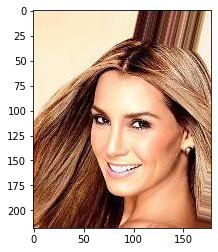

In [ ]:
# Just visualize the first sample and labels leveraging dataset.attr_names
image, label = 






### Training

Create the datasets and dataloaders.

(Using `batch_size=64, num_workers=2`)

Dataset CelebA
    Number of datapoints: 162770
    Root location: .
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=(96, 96), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


Implement a model for the task of multi-label classification.

The basic cell is of `Conv-BN-ReLU`. Normal and Reduced cell (max pooling) alternate.

Create an instance of the model, optimizer and standard criterion.

>>> model MultiClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLa

Define the metric (accuracy) calculation function.

Implement run on one epoch.

In [ ]:
def fit_model(epochs, model, dataloader, phase='training'):
    """
    Returns:
        total_batch_loss (float)
        total_batch_acc (float)
    """
    

























Train and save the model.

In [ ]:
trn_losses = []; trn_acc = []
val_losses = []; val_acc = []
for i in range(10):
    trn_l, trn_a = fit_model(i, model, train_dataloader)
    val_l, val_a = fit_model(i, model, valid_dataloader, phase='validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)
    torch.save(model, 'model.pth')  # save the model trained

'Epoch: 0'
'Iteration 499: loss 0.2945, acc 0.8699'
'Iteration 999: loss 0.2946, acc 0.8691'
'Iteration 1499: loss 0.2983, acc 0.8719'
'Iteration 1999: loss 0.2641, acc 0.8797'
'Iteration 2499: loss 0.2645, acc 0.8883'
'training loss is 0.2938963747788338 '
'training accuracy is 0.8720536944954276 '
'Epoch: 0'
'validation loss is 0.27018441901904594 '
'validation accuracy is 0.8829354507746804 '
'Epoch: 1'
'Iteration 499: loss 0.2727, acc 0.8793'
'Iteration 999: loss 0.2738, acc 0.8809'
'Iteration 1499: loss 0.2562, acc 0.8887'
'Iteration 1999: loss 0.2725, acc 0.8883'
'Iteration 2499: loss 0.2627, acc 0.8918'
'training loss is 0.26404856367962165 '
'training accuracy is 0.8845482362469412 '
'Epoch: 1'
'validation loss is 0.2593776438013917 '
'validation accuracy is 0.8864999674140832 '
'Epoch: 2'
'Iteration 499: loss 0.2486, acc 0.8945'
'Iteration 999: loss 0.2613, acc 0.8805'
'Iteration 1499: loss 0.2571, acc 0.8883'
'Iteration 1999: loss 0.2613, acc 0.8840'
'Iteration 2499: loss 0.2

Save the model to the drive.

In [ ]:
!cp model.pth '$drive_root'

Plot the training.

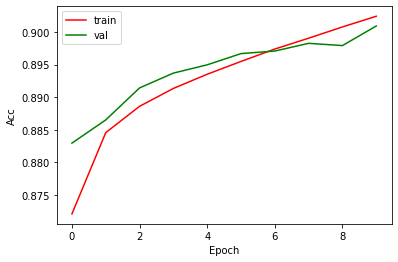

### Inference

Load the saved trained model.

Implement inference of one sample.

In [ ]:
def predict(img, model):
    """
    Returns:
       pred_scores (List[Tuple[str, float]]): Predictions of multi labels and
           the corresponding scores in descending order of accuracy.
    """

    
    






    

See the effects.

11 correct predictions [('No_Beard', '1.0000'), ('Mouth_Slightly_Open', '0.9999'), ('Smiling', '0.9991'), ('Young', '0.9985'), ('Wearing_Lipstick', '0.9982'), ('Attractive', '0.9794'), ('Heavy_Makeup', '0.9782'), ('High_Cheekbones', '0.9191'), ('Arched_Eyebrows', '0.7234'), ('Brown_Hair', '0.7110'), ('Pointy_Nose', '0.6384')]
1 wrong predictions [('Wavy_Hair', '0.7152')]
2 missing attributes [('Wearing_Earrings', '0.2408'), ('Straight_Hair', '0.0756')]
13 label ['Arched_Eyebrows', 'Attractive', 'Brown_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Pointy_Nose', 'Smiling', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young']


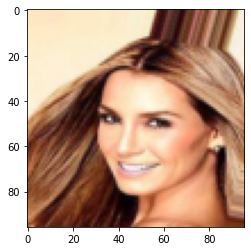

### Pruning

> State-of-the-art deep learning techniques rely on over-parametrized models 
that are hard to deploy. On the contrary, biological neural networks are 
known to use efficient sparse connectivity. Identifying optimal techniques to compress models by reducing the number of parameters in them is 
important in order to reduce memory, battery, and hardware consumption without 
sacrificing accuracy, deploy lightweight models on device, and guarantee 
privacy with private on-device computation. On the research front, pruning is 
used to investigate the differences in learning dynamics between 
over-parametrized and under-parametrized networks, to study the role of lucky 
sparse subnetworks and initializations
("[lottery tickets](https://arxiv.org/pdf/1803.03635.pdf)") as a destructive 
neural architecture search technique, and more.

In this tutorial, you will learn how to use ``torch.nn.utils.prune`` to 
sparsify your neural networks, and how to extend it to implement your 
own custom pruning technique.





In [ ]:
import torch.nn.utils.prune as prune

Let's inspect the (unpruned) ``conv1`` layer in our model.



In [ ]:
model = model.cuda()
module = model.ConvLayer1[0]
print(list(module.named_parameters()))

[('weight', Parameter containing:
tensor([[[[-0.4993,  0.2184,  0.0611],
          [-0.2602,  0.6346, -0.3661],
          [ 0.1196,  0.0173,  0.0231]],

         [[-0.4177,  0.5760, -0.1180],
          [ 0.0091,  0.7275, -0.4873],
          [ 0.1324, -0.1090, -0.3060]],

         [[-0.3173,  0.4458, -0.0379],
          [-0.0141,  0.6268, -0.4951],
          [-0.0979, -0.0011, -0.1139]]],


        [[[-0.0133,  0.0209,  0.0221],
          [ 0.1703, -0.1929,  0.1645],
          [ 0.1389, -0.0603,  0.0070]],

         [[ 0.1885, -0.0496, -0.0446],
          [ 0.1504, -0.1289,  0.1221],
          [-0.0754,  0.1942,  0.1311]],

         [[-0.0078, -0.2607, -0.1043],
          [-0.0517, -0.0681, -0.0605],
          [ 0.0821, -0.0496,  0.0873]]],


        [[[-0.0897, -0.2872,  0.1466],
          [ 0.2746,  0.2181,  0.1618],
          [-0.0175, -0.2983, -0.1029]],

         [[-0.1196, -0.3299,  0.0193],
          [ 0.4625,  0.1549,  0.2471],
          [-0.1581, -0.2410,  0.0119]],

         [

In [ ]:
print(list(module.named_buffers()))

[]


#### Random Pruning

To prune a module (in this example, the ``conv1`` layer of our
architecture), first select a pruning technique among those available in 
``torch.nn.utils.prune``. Then, specify the module and the name of the parameter to 
prune within that module. Finally, using the adequate keyword arguments 
required by the selected pruning technique, specify the pruning parameters.

In this example, we will prune at random 30% of the connections in 
the parameter named ``weight`` in the ``conv1`` layer.
The module is passed as the first argument to the function; ``name`` 
identifies the parameter within that module using its string identifier; and 
``amount`` indicates either the percentage of connections to prune (if it 
is a float between 0. and 1.), or the absolute number of connections to 
prune (if it is a non-negative integer).



In [ ]:
prune.random_unstructured(module, name="weight", amount=0.3)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Pruning acts by removing ``weight`` from the parameters and replacing it with 
a new parameter called ``weight_orig`` (i.e. appending ``"_orig"`` to the 
initial parameter ``name``). ``weight_orig`` stores the unpruned version of 
the tensor. The ``bias`` was not pruned, so it will remain intact.



In [ ]:
print(list(module.named_parameters()))

[('weight_orig', Parameter containing:
tensor([[[[-0.4993,  0.2184,  0.0611],
          [-0.2602,  0.6346, -0.3661],
          [ 0.1196,  0.0173,  0.0231]],

         [[-0.4177,  0.5760, -0.1180],
          [ 0.0091,  0.7275, -0.4873],
          [ 0.1324, -0.1090, -0.3060]],

         [[-0.3173,  0.4458, -0.0379],
          [-0.0141,  0.6268, -0.4951],
          [-0.0979, -0.0011, -0.1139]]],


        [[[-0.0133,  0.0209,  0.0221],
          [ 0.1703, -0.1929,  0.1645],
          [ 0.1389, -0.0603,  0.0070]],

         [[ 0.1885, -0.0496, -0.0446],
          [ 0.1504, -0.1289,  0.1221],
          [-0.0754,  0.1942,  0.1311]],

         [[-0.0078, -0.2607, -0.1043],
          [-0.0517, -0.0681, -0.0605],
          [ 0.0821, -0.0496,  0.0873]]],


        [[[-0.0897, -0.2872,  0.1466],
          [ 0.2746,  0.2181,  0.1618],
          [-0.0175, -0.2983, -0.1029]],

         [[-0.1196, -0.3299,  0.0193],
          [ 0.4625,  0.1549,  0.2471],
          [-0.1581, -0.2410,  0.0119]],

     

The pruning mask generated by the pruning technique selected above is saved 
as a module buffer named ``weight_mask`` (i.e. appending ``"_mask"`` to the 
initial parameter ``name``).



In [ ]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[1., 1., 0.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 0.],
          [0., 0., 1.],
          [0., 1., 0.]],

         [[1., 1., 1.],
          [0., 0., 0.],
          [0., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 0.]],

         [[1., 1., 1.],
          [1., 0., 1.],
          [0., 0., 1.]],

         [[1., 1., 0.],
          [1., 1., 0.],
          [1., 0., 1.]]],


        [[[0., 1., 0.],
          [1., 1., 0.],
          [1., 0., 1.]],

         [[0., 1., 1.],
          [1., 1., 1.],
          [0., 1., 1.]],

         [[1., 0., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        ...,


        [[[1., 1., 1.],
          [1., 1., 1.],
          [0., 1., 1.]],

         [[0., 1., 1.],
          [1., 0., 1.],
          [1., 1., 1.]],

         [[1., 0., 1.],
          [1., 1., 0.],
          [1., 1., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 0.]],

For the forward pass to work without modification, the ``weight`` attribute 
needs to exist. The pruning techniques implemented in 
``torch.nn.utils.prune`` compute the pruned version of the weight (by 
combining the mask with the original parameter) and store them in the 
attribute ``weight``. Note, this is no longer a parameter of the ``module``,
it is now simply an **attribute**.



In [ ]:
print(module.weight)

tensor([[[[-0.4993,  0.2184,  0.0000],
          [-0.2602,  0.6346, -0.3661],
          [ 0.1196,  0.0173,  0.0231]],

         [[-0.4177,  0.5760, -0.0000],
          [ 0.0000,  0.0000, -0.4873],
          [ 0.0000, -0.1090, -0.0000]],

         [[-0.3173,  0.4458, -0.0379],
          [-0.0000,  0.0000, -0.0000],
          [-0.0000, -0.0011, -0.1139]]],


        [[[-0.0133,  0.0209,  0.0221],
          [ 0.1703, -0.1929,  0.1645],
          [ 0.1389, -0.0603,  0.0000]],

         [[ 0.1885, -0.0496, -0.0446],
          [ 0.1504, -0.0000,  0.1221],
          [-0.0000,  0.0000,  0.1311]],

         [[-0.0078, -0.2607, -0.0000],
          [-0.0517, -0.0681, -0.0000],
          [ 0.0821, -0.0000,  0.0873]]],


        [[[-0.0000, -0.2872,  0.0000],
          [ 0.2746,  0.2181,  0.0000],
          [-0.0175, -0.0000, -0.1029]],

         [[-0.0000, -0.3299,  0.0193],
          [ 0.4625,  0.1549,  0.2471],
          [-0.0000, -0.2410,  0.0119]],

         [[ 0.0465, -0.0000,  0.1233],
     

Finally, pruning is applied prior to each forward pass using PyTorch's
``forward_pre_hooks``. Specifically, when the ``module`` is pruned, as we 
have done here, it will acquire a ``forward_pre_hook`` for each parameter 
associated with it that gets pruned. In this case, since we have so far 
only pruned the original parameter named ``weight``, only one hook will be
present.



In [ ]:
print(module._forward_pre_hooks)

OrderedDict([(18, <torch.nn.utils.prune.RandomUnstructured object at 0x7f5d477cfac8>)])


#### L1 Norm Pruning

Just for the sake of trying out another pruning technique, here we prune the 
3 smallest entries in the weight by L1 norm, as implemented in the 
``l1_unstructured`` pruning function.



In [ ]:
prune.l1_unstructured(module, name="weight", amount=0.3)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [ ]:
print(list(module.named_parameters()))

[('weight_orig', Parameter containing:
tensor([[[[-0.4993,  0.2184,  0.0611],
          [-0.2602,  0.6346, -0.3661],
          [ 0.1196,  0.0173,  0.0231]],

         [[-0.4177,  0.5760, -0.1180],
          [ 0.0091,  0.7275, -0.4873],
          [ 0.1324, -0.1090, -0.3060]],

         [[-0.3173,  0.4458, -0.0379],
          [-0.0141,  0.6268, -0.4951],
          [-0.0979, -0.0011, -0.1139]]],


        [[[-0.0133,  0.0209,  0.0221],
          [ 0.1703, -0.1929,  0.1645],
          [ 0.1389, -0.0603,  0.0070]],

         [[ 0.1885, -0.0496, -0.0446],
          [ 0.1504, -0.1289,  0.1221],
          [-0.0754,  0.1942,  0.1311]],

         [[-0.0078, -0.2607, -0.1043],
          [-0.0517, -0.0681, -0.0605],
          [ 0.0821, -0.0496,  0.0873]]],


        [[[-0.0897, -0.2872,  0.1466],
          [ 0.2746,  0.2181,  0.1618],
          [-0.0175, -0.2983, -0.1029]],

         [[-0.1196, -0.3299,  0.0193],
          [ 0.4625,  0.1549,  0.2471],
          [-0.1581, -0.2410,  0.0119]],

     

In [ ]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[1., 1., 0.],
          [1., 1., 1.],
          [1., 0., 0.]],

         [[1., 1., 0.],
          [0., 0., 1.],
          [0., 1., 0.]],

         [[1., 1., 0.],
          [0., 0., 0.],
          [0., 0., 1.]]],


        [[[0., 0., 0.],
          [1., 1., 1.],
          [1., 0., 0.]],

         [[1., 0., 0.],
          [1., 0., 1.],
          [0., 0., 1.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [1., 0., 1.]]],


        [[[0., 1., 0.],
          [1., 1., 0.],
          [0., 0., 1.]],

         [[0., 1., 0.],
          [1., 1., 1.],
          [0., 1., 0.]],

         [[0., 0., 1.],
          [1., 1., 0.],
          [1., 1., 0.]]],


        ...,


        [[[1., 1., 1.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[0., 1., 1.],
          [0., 0., 1.],
          [0., 0., 1.]],

         [[1., 0., 1.],
          [1., 1., 0.],
          [0., 0., 1.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [0., 0., 0.]],

In [ ]:
print(module._forward_pre_hooks)

OrderedDict([(19, <torch.nn.utils.prune.PruningContainer object at 0x7f5d477cf748>)])


#### Structured Pruning

The same parameter in a module can be pruned multiple times, with the 
effect of the various pruning calls being equal to the combination of the
various masks applied in series.
The combination of a new mask with the old mask is handled by the 
``PruningContainer``'s ``compute_mask`` method.

Say, for example, that we now want to further prune ``module.weight``, this
time using structured pruning along the 0th axis of the tensor (the 0th axis 
corresponds to the output channels of the convolutional layer and has 
dimensionality 64 for ``conv1``), based on the channels' L2 norm. This can be 
achieved using the ``ln_structured`` function, with ``n=2`` and ``dim=0``.



In [ ]:
prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)

# As we can verify, this will zero out all the connections corresponding to 
# 50% of the channels, while preserving the action of the 
# previous mask.
print(module.weight)

tensor([[[[-0.4993,  0.2184,  0.0000],
          [-0.2602,  0.6346, -0.3661],
          [ 0.1196,  0.0000,  0.0000]],

         [[-0.4177,  0.5760, -0.0000],
          [ 0.0000,  0.0000, -0.4873],
          [ 0.0000, -0.1090, -0.0000]],

         [[-0.3173,  0.4458, -0.0000],
          [-0.0000,  0.0000, -0.0000],
          [-0.0000, -0.0000, -0.1139]]],


        [[[-0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000]],

         [[ 0.0000, -0.0000, -0.0000],
          [ 0.0000, -0.0000,  0.0000],
          [-0.0000,  0.0000,  0.0000]],

         [[-0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000],
          [ 0.0000, -0.0000,  0.0000]]],


        [[[-0.0000, -0.2872,  0.0000],
          [ 0.2746,  0.2181,  0.0000],
          [-0.0000, -0.0000, -0.1029]],

         [[-0.0000, -0.3299,  0.0000],
          [ 0.4625,  0.1549,  0.2471],
          [-0.0000, -0.2410,  0.0000]],

         [[ 0.0000, -0.0000,  0.1233],
     

The corresponding hook will now be of type 
``torch.nn.utils.prune.PruningContainer``, and will store the history of 
pruning applied to the ``weight`` parameter.



In [ ]:
for hook in module._forward_pre_hooks.values():
    if hook._tensor_name == "weight":  # select out the correct hook
        break

print(list(hook))  # pruning history in the container

[<torch.nn.utils.prune.RandomUnstructured object at 0x7f5d477cfac8>, <torch.nn.utils.prune.L1Unstructured object at 0x7f5d477cf518>, <torch.nn.utils.prune.LnStructured object at 0x7f5d466a5be0>]


All relevant tensors, including the mask buffers and the original parameters
used to compute the pruned tensors are stored in the model's ``state_dict`` 
and can therefore be easily serialized and saved, if needed.



In [ ]:
print(model.state_dict().keys())

odict_keys(['ConvLayer1.0.weight_orig', 'ConvLayer1.0.weight_mask', 'ConvLayer1.1.weight', 'ConvLayer1.1.bias', 'ConvLayer1.1.running_mean', 'ConvLayer1.1.running_var', 'ConvLayer1.1.num_batches_tracked', 'ConvLayer2.0.weight', 'ConvLayer2.1.weight', 'ConvLayer2.1.bias', 'ConvLayer2.1.running_mean', 'ConvLayer2.1.running_var', 'ConvLayer2.1.num_batches_tracked', 'ConvLayer3.0.weight', 'ConvLayer3.1.weight', 'ConvLayer3.1.bias', 'ConvLayer3.1.running_mean', 'ConvLayer3.1.running_var', 'ConvLayer3.1.num_batches_tracked', 'ConvLayer4.0.weight', 'ConvLayer4.1.weight', 'ConvLayer4.1.bias', 'ConvLayer4.1.running_mean', 'ConvLayer4.1.running_var', 'ConvLayer4.1.num_batches_tracked', 'Linear1.weight', 'Linear1.bias', 'Linear2.weight', 'Linear2.bias'])


#### Global Pruning

So far, we only looked at what is usually referred to as "local" pruning,
i.e. the practice of pruning tensors in a model one by one, by 
comparing the statistics (weight magnitude, activation, gradient, etc.) of 
each entry exclusively to the other entries in that tensor. However, a 
common and perhaps more powerful technique is to prune the model all at 
once, by removing (for example) the lowest 20% of connections across the 
whole model, instead of removing the lowest 20% of connections in each 
layer. This is likely to result in different pruning percentages per layer.
Let's see how to do that using ``global_unstructured`` from 
``torch.nn.utils.prune``.



In [ ]:
model = MultiClassifier()
model = torch.load(os.path.join(drive_root, 'model.pth')).cuda()

parameters_to_prune = (
    (model.ConvLayer1[0], 'weight'),
    (model.ConvLayer2[0], 'weight'),
    (model.ConvLayer3[0], 'weight'),
    (model.ConvLayer4[0], 'weight'),
    (model.Linear1, 'weight'),
    (model.Linear2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

Now we can check the sparsity induced in every pruned parameter, which will 
not be equal to 20% in each layer. However, the global sparsity will be 
(approximately) 20%.



In [ ]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.ConvLayer1[0].weight == 0))
        / float(model.ConvLayer1[0].weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.ConvLayer2[0].weight == 0))
        / float(model.ConvLayer2[0].weight.nelement())
    )
)
print(
    "Sparsity in conv3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.ConvLayer3[0].weight == 0))
        / float(model.ConvLayer3[0].weight.nelement())
    )
)
print(
    "Sparsity in conv4.weight: {:.2f}%".format(
        100. * float(torch.sum(model.ConvLayer4[0].weight == 0))
        / float(model.ConvLayer4[0].weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.Linear1.weight == 0))
        / float(model.Linear1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.Linear2.weight == 0))
        / float(model.Linear2.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(model.ConvLayer1[0].weight == 0)
            + torch.sum(model.ConvLayer2[0].weight == 0)
            + torch.sum(model.ConvLayer3[0].weight == 0)
            + torch.sum(model.ConvLayer4[0].weight == 0)
            + torch.sum(model.Linear1.weight == 0)
            + torch.sum(model.Linear2.weight == 0)
        )
        / float(
            model.ConvLayer1[0].weight.nelement()
            + model.ConvLayer2[0].weight.nelement()
            + model.ConvLayer3[0].weight.nelement()
            + model.ConvLayer4[0].weight.nelement()
            + model.Linear1.weight.nelement()
            + model.Linear2.weight.nelement()
        )
    )
)

Sparsity in conv1.weight: 0.81%
Sparsity in conv2.weight: 3.84%
Sparsity in conv3.weight: 5.51%
Sparsity in conv4.weight: 8.13%
Sparsity in fc1.weight: 22.10%
Sparsity in fc2.weight: 4.22%
Global sparsity: 20.00%


#### Pruning Re-parametrization

To make the pruning permanent, remove the re-parametrization in terms
of ``weight_orig`` and ``weight_mask``, and remove the ``forward_pre_hook``,
we can use the ``remove`` functionality from ``torch.nn.utils.prune``.
Note that this doesn't undo the pruning, as if it never happened. It simply 
makes it permanent, instead, by reassigning the parameter ``weight`` to the 
model parameters, in its pruned version.



In [ ]:
module = model.ConvLayer1[0]
prune.remove(module, 'weight')
print(list(module.named_parameters()))

[('weight', Parameter containing:
tensor([[[[-0.4993,  0.2184,  0.0611],
          [-0.2602,  0.6346, -0.3661],
          [ 0.1196,  0.0173,  0.0231]],

         [[-0.4177,  0.5760, -0.1180],
          [ 0.0091,  0.7275, -0.4873],
          [ 0.1324, -0.1090, -0.3060]],

         [[-0.3173,  0.4458, -0.0379],
          [-0.0141,  0.6268, -0.4951],
          [-0.0979, -0.0000, -0.1139]]],


        [[[-0.0133,  0.0209,  0.0221],
          [ 0.1703, -0.1929,  0.1645],
          [ 0.1389, -0.0603,  0.0070]],

         [[ 0.1885, -0.0496, -0.0446],
          [ 0.1504, -0.1289,  0.1221],
          [-0.0754,  0.1942,  0.1311]],

         [[-0.0078, -0.2607, -0.1043],
          [-0.0517, -0.0681, -0.0605],
          [ 0.0821, -0.0496,  0.0873]]],


        [[[-0.0897, -0.2872,  0.1466],
          [ 0.2746,  0.2181,  0.1618],
          [-0.0175, -0.2983, -0.1029]],

         [[-0.1196, -0.3299,  0.0193],
          [ 0.4625,  0.1549,  0.2471],
          [-0.1581, -0.2410,  0.0119]],

         [

In [ ]:
print(list(module.named_buffers()))

[]


#### Testing

In [ ]:
val_l, val_a = fit_model(0, model, valid_dataloader, phase='validation')

'Epoch: 0'
'validation loss is 0.20283628885194036 '
'validation accuracy is 0.911633258272214 '


### Acknowledge

[Vatsal Saglani](https://github.com/vatsalsaglani) and [Michela Paganini](https://github.com/mickypaganini) for providing some of thoughts and materials.